<a href="https://colab.research.google.com/github/sgwinnerCE/ETL_Ameba/blob/main/ETL_Ameba_CE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd #1.5.3
import os
pd.__version__

'1.5.3'

# Changelog

- Refactoring
  - Actualizacion de funcion append a concat
  - Mejora de manejo de rutas (parametrizacion y uso de metodo sep.join())
  - Ordenamiento de funciones en notebook para mejor lectura
  - Funciones auxiliares para evitar repeticion de codigo.
  - Parametrizacion de rutas y eleccion de funciones a ejecutar
  - Simplificacion de calculo de capacidad nueva y acumulada
  - Correccion de warnings (funcion append y agrupaciones)
  - Separacion de funciones en celdas distintas
  - Filtros en lectura de datos (mejora de tiempos)
  - Se combina funcion de generacion horaria y anual.
- Funcion resumen de CMg
- Funcion de chequeos y warnings si hay errores en datos.
- Mejora y adicion de warnings a inversiones de lineas.
- Mejora de procesamiento de resumen de emisiones y costos totales. Anteriormente se leian dos archivos separados para extraer esa informacion, sin embargo todo se encuentra disponble en archivo system

# TODO

- Actualizacion y revisión de resumenes.

# Revisar caso central Alfa Solar, posible error!

Capacidad nueva de alfa solar en escenario TA, central esta como plan de obra y como expansion.

# Dudas

- Revisar si costo start/stop es la repeticion del costo de la etapa en cada bloque (funcion de costos)
- Proposito de funciones de corto plazo (iguales que las otras)

#Entradas y Archivos

In [3]:
path  = r"/content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7"
carpeta_diccionarios = 'Diccionarios'
carpeta_datos = 'Base de Datos'
carpeta_resultados = 'Resumenes'

nombre_diccionario_centrales = 'BD generadores PELP2023-2027_v9.csv'
nombre_diccionario_barras = 'BD barras.csv'
nombre_diccionario_lineas = 'BD LTx_v2.csv'
nombre_diccionario_agrupacion = 'Tecnologia_Filtro.csv'

path_diccionarios = os.sep.join([path, carpeta_diccionarios])
path_datos_ameba = os.sep.join([path, carpeta_datos])
path_resultados = os.sep.join([path, carpeta_resultados])

path_centrales = os.sep.join([path_diccionarios, nombre_diccionario_centrales])
path_barras = os.sep.join([path_diccionarios, nombre_diccionario_barras])
path_lineas = os.sep.join([path_diccionarios, nombre_diccionario_lineas])
agrupacion_tec = os.sep.join([path_diccionarios, nombre_diccionario_agrupacion])

AGNO_INICIO = 2020
AGNO_FIN = 2060

idx=pd.date_range('2020-01-01', '2061-01-01',freq='Y').year
idx_cp=pd.date_range('2020-01-01', '2061-01-01',freq='Y').year #modificar al año específico 2025 o 2030

print(f'Directorios:')
print(f'Ruta principal: {path}')
print(f'Ruta datos Ameba: {path_datos_ameba}')
print(f'Ruta resultados: {path_resultados}')
print(f'Diccionario centrales: {path_centrales}')
print(f'Diccionario barras: {path_barras}')
print(f'Diccionario lineas: {path_lineas}')
print(f'Diccionario agrupación de tecnologías: {agrupacion_tec}')

Directorios:
Ruta principal: /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7
Ruta datos Ameba: /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Base de Datos
Ruta resultados: /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Resumenes
Diccionario centrales: /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Diccionarios/BD generadores PELP2023-2027_v9.csv
Diccionario barras: /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Diccionarios/BD barras.csv
Diccionario lineas: /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Diccionarios/BD LTx_v2.csv
Diccionario agrupación de tecnologías: /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Diccionarios/Tecnologia_Filtro.csv


## Eleccion de funciones a ejecutar

In [4]:
Generacion_Anual = False
Generacion_Horaria = False
Transmision = False
Emisiones_Anuales = False
Capacidad_Total = False
Capacidad_Nueva = False

# Funciones utiles

In [5]:
def encontrar_rutas_archivos(ruta:str, palabra_clave: str) -> list[str] | list[str]:
    filepath = []
    for root, dirs, files in os.walk(ruta):
      if dirs: #directorio no vacio
        Escenarios=dirs
      for name in files:
        if palabra_clave in name:
          # filepath.append(root + os.sep + name)
          filepath.append(os.sep.join([root, name]))
    return filepath, Escenarios


def chequeo_elementos(df: pd.DataFrame, lista_elementos: list[str], nombre_columna:str) -> set:
    lista_elementos_archivo = list(df[nombre_columna].unique())
    diferencia = set(lista_elementos_archivo).difference(lista_elementos)
    return diferencia

#Funciones Largo Plazo

##  Generacion Anual

In [ ]:
def generacion_anual() -> None:

    df_final = pd.DataFrame()

    filepath, Escenarios = encontrar_rutas_archivos(path_datos_ameba, "di_generation")

    columnas_centrales = ['name','tecnologia', 'region', 'co2 emission','PMGD', 'busbar']
    df_centrales = pd.read_csv(path_centrales, sep=',', encoding="ISO-8859-1", usecols=columnas_centrales)
    df_centrales.rename({'name':'element_name', 'busbar':'Barra'}, axis=1, inplace=True)

    lista_elementos_dicc = list(df_centrales.element_name.unique())

    df_agrupacion_tec=pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")

    columnas = ['tuple','element_name', 'year', 'month', 'block_id', 'Generated energy [GWh]', 'Generation [MW]']

    error_elementos = set()
    indice = 0
    for archivo in filepath:
        escenario = Escenarios[indice]
        print (f'Procesando {escenario}')
        df_escenario = pd.read_csv(archivo, sep= ',', usecols=columnas)
        error_elementos_escenario = chequeo_elementos(df_escenario, lista_elementos_dicc, 'element_name')
        error_elementos = error_elementos.union(error_elementos_escenario)
        df_escenario = pd.merge(df_escenario, df_centrales[['element_name','tecnologia']], on='element_name', how='left')
        df_escenario = df_escenario.groupby(['tuple','tecnologia','element_name','year','month', 'block_id']).sum().reset_index()
        df_escenario = pd.merge(df_escenario, df_centrales[['element_name','region']], on='element_name', how='left')
        df_escenario['Escenario'] = escenario
        df_final = pd.concat([df_final, df_escenario])
        indice += 1

    if len(error_elementos)>0:
        print('------------------------------------------------------')
        print(f'WARNING: Los siguientes elementos no existen en diccionario {nombre_diccionario_centrales}')
        for central in  error_elementos:
            print(central)
        print('------------------------------------------------------')

    renombre_columnas={
        'tuple':'Hidrologia',
        'element_name':'Nombre',
        'year':'Año',
        'region':'Region',
        'Generated energy [GWh]':'Generación [GWh]',
        'Generation [MW]':'Generación [MW]',
        'tecnologia':'Tecnologia',
        'month': 'Mes',
        'block_id':'Hora'
    }

    df_final.rename(columns=renombre_columnas, inplace=True)

    aux2=df_centrales.loc[:,["element_name","co2 emission","PMGD", 'Barra']] #seleccion las columnas que quiero agregar
    aux2['PMGD'].fillna(value=0,inplace=True)
    aux2 = aux2.rename({'element_name':'Nombre'},axis=1) #hago coincidir el nombre de la columna para la union
    df_final = pd.merge(df_final,aux2,how='left',on='Nombre')

    #agrego columna con tecnologias agrupadas
    df_final = pd.merge(df_final,df_agrupacion_tec,how='left',on='Tecnologia')

    #emisiones co2
    df_final["Emisiones [tonCO2eq]"] = round(df_final['Generación [GWh]']*df_final["co2 emission"],4)
    df_final=df_final.drop(["co2 emission"], axis=1)

    df_final["Generación [GWh]"]=round(df_final["Generación [GWh]"],4)

    df_horario = df_final.groupby(['Hidrologia','Tecnologia','Mes','Hora','Barra','Año', 'Escenario', 'Agrupacion Tecnologia'])['Generación [MW]'].sum().reset_index()
    ruta_final = os.sep.join([path_resultados, 'Generacion_horaria.csv'])
    print(f'Guardando generacion horaria en {ruta_final}')
    df_horario.to_csv(ruta_final,index=False,encoding='utf-8-sig',sep=',')

    df_horario_reducido = df_horario.groupby(['Año','Hora','Mes','Hidrologia','Barra','Escenario','Agrupacion Tecnologia'])['Generación [MW]'].sum().reset_index()
    ruta = os.sep.join([path_resultados, 'Generacion_horaria_reducida.csv'])
    print(f'Guardando generacion horaria reducida en {ruta}')
    df_horario_reducido.to_csv(ruta, index=False,encoding='utf-8-sig',sep=',')

    df_horario_reducido_simple = df_horario_reducido.groupby(['Año','Hora','Mes','Hidrologia','Escenario','Agrupacion Tecnologia'])['Generación [MW]'].sum().reset_index()
    ruta = os.sep.join([path_resultados, 'Generacion_horaria_reducida_simple.csv'])
    print(f'Guardando generacion horaria reducida simple en {ruta}')
    df_horario_reducido_simple.to_csv(ruta, index=False,encoding='utf-8-sig',sep=',')

    df_anual = df_final.groupby(['Hidrologia','Tecnologia','Nombre','Año', 'Region', 'Escenario','PMGD','Agrupacion Tecnologia'])[['Generación [GWh]', 'Emisiones [tonCO2eq]']].sum().reset_index()
    ruta = os.sep.join([path_resultados, 'Generacion_anual.csv'])
    print(f'Guardando generacion anual en {ruta}')
    df_anual.to_csv(ruta,index=False,encoding='utf-8-sig',sep=',')


    df_anual_reducida = df_anual.groupby(['Hidrologia','Año', 'Region', 'Escenario','PMGD','Agrupacion Tecnologia'])[['Generación [GWh]', 'Emisiones [tonCO2eq]']].sum().reset_index()
    ruta = os.sep.join([path_resultados, 'Generacion_anual_reducida.csv'])
    print(f'Guardando generacion anual reducida en {ruta}')
    df_anual_reducida.to_csv(ruta,index=False,encoding='utf-8-sig',sep=',')

generacion_anual()

Procesando CN_PELPV7
Procesando RL_PELPV7
Procesando TA_PELPV7
------------------------------------------------------
Ampliacin PMGD El Boco
PMGD FV Coihueco Vicente Mendez
Las Aranas 1 13.2 II
PMGD FV Watt's Lonquen
PMGD Playero Etapa II
BG02_Parinacota
Vicuna 023 II
Panimavida
BG01_Lagunas
BG04_Chacaya
PMGD FV Quillen I
PFV Las Cachanas
PMGD FV Nahuen
BG03_Tarapaca
------------------------------------------------------
Guardando generacion horaria en /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Resumenes/Generacion_horaria.csv
Guardando generacion horaria reducida en /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Resumenes/Generacion_horaria_reducida.csv
Guardando generacion horaria reducida simple en /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Resumenes/Generacion_horaria_reducida_simple.csv
Guardando generacion anual en /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Resumenes/Generacion_anual.csv
Guardando generacion anual reducida en /content/drive/MyDrive/10 DPS CCEE/PEL

## Costos marginales

In [ ]:
def costos_marginales() -> None:
    filepath, Escenarios = encontrar_rutas_archivos(path_datos_ameba, "di_marginal_cost")
    columnas = ['element_name','year','month','block_id','tuple', 'Marginal price [USD/MWh]']
    df_final = pd.DataFrame()
    indice = 0
    for archivo in filepath:
        escenario = Escenarios[indice]
        print (f'Procesando {escenario}')
        df_escenario = pd.read_csv(archivo, sep= ',', usecols=columnas)
        df_escenario['Escenario'] = escenario
        df_final = pd.concat([df_final, df_escenario])
        indice += 1

    renombre_columnas={
        'tuple':'Hidrologia',
        'element_name':'Barra',
        'year':'Año',
        'month':'Mes',
        'block_id':'Hora',
        'Marginal price [USD/MWh]':'Costo Marginal [USD/MWh]',
    }

    df_final.rename(renombre_columnas, axis=1, inplace=True)
    ruta_final = os.sep.join([path_resultados, 'Costo_Marginal.csv'])
    print(f'Guardando CMg en {ruta_final}')
    df_final.to_csv(ruta_final,index=False,encoding='utf-8-sig',sep=',')
costos_marginales()

Procesando CN_PELPV7
Procesando RL_PELPV7
Procesando TA_PELPV7
Guardando CMg en /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Resumenes/Costo_Marginal.csv


## Capacidad nueva

In [ ]:
def capacidad_nueva():
    df_final=pd.DataFrame()

    columnas = ['scenario', 'generator', 'technology', 'value [MW]','time']
    df_agrupacion_tec = pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")
    df_centrales      = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
    filepath, Escenarios = encontrar_rutas_archivos(path_datos_ameba, "_Generation investment [MW]")

    lista_agnos = list(range(AGNO_INICIO, AGNO_FIN+1))
    df_agnos = pd.DataFrame({'Año': lista_agnos})
    indice = 0
    for archivo in filepath:
        escenario = Escenarios[indice]
        print (f'Procesando {escenario}')
        df = pd.read_csv(archivo, usecols=columnas)
        df['Año']=(pd.DatetimeIndex(df.time)).year
        del df['time']
        lista_hidros = list(df.scenario.unique())
        for hid in lista_hidros:
            df_hidro = df.loc[(df.scenario ==hid)]
            lista_centrales = list(df_hidro.generator.unique())
            for central in lista_centrales:
                df_central =  df_hidro.loc[df_hidro.generator == central]
                df_central = df_agnos.merge(df_central, how='left', on='Año')
                df_central[['scenario', 'generator', 'technology']] = df_central[['scenario', 'generator', 'technology']].bfill()
                df_central[['scenario', 'generator', 'technology']] = df_central[['scenario', 'generator', 'technology']].ffill()
                df_central['Capacidad Acumulado [MW]'] = df_central['value [MW]']
                df_central[['value [MW]']] = df_central[['value [MW]']].fillna(0)
                df_central[['Capacidad Acumulado [MW]']] = df_central[['Capacidad Acumulado [MW]']].ffill()
                df_central[['Capacidad Acumulado [MW]']] = df_central[['Capacidad Acumulado [MW]']].fillna(0)
                df_central['Escenario'] = escenario
                df_final = pd.concat([df_final, df_central])

        indice += 1
    df_final.reset_index(drop=True, inplace=True)

    renombre_columnas={
        'scenario':'Hidrologia',
        'generator':'Nombre',
        'value [MW]':'Capacidad [MW]',
        'technology':'Tecnologia',
        'Marginal price [USD/MWh]':'Costo Marginal [USD/MWh]',
    }

    df_final.rename(renombre_columnas, axis=1, inplace=True)

    aux2=df_centrales.loc[:,["name","tecnologia","region","PMGD"]] #seleccion las columnas que quiero agregar desde la BD de Centrales
    aux2['PMGD'].fillna(value=0,inplace=True)
    aux2 = aux2.rename({'name':'Nombre'},axis=1)
    df_final = pd.merge(df_final,aux2,how='left',on='Nombre')

    df_agrupacion_tec=pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1") #agregar columna de agrupacion de tecnologias
    df_final = pd.merge(df_final,df_agrupacion_tec,how='left',on='Tecnologia')

    ruta_final = os.sep.join([path_resultados, 'Capacidad_nueva.csv'])
    print(f'Guardando capacidad nueva en {ruta_final}')
    df_final.to_csv(ruta_final,index=False,encoding='utf-8-sig',sep=',')
capacidad_nueva()

Procesando CN_PELPV7
Procesando RL_PELPV7
Procesando TA_PELPV7
Guardando capacidad nueva en /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Resumenes/Capacidad_nueva.csv


## Capacidad Total

In [ ]:
def capacidad_total() -> None:

    filepath, Escenarios = encontrar_rutas_archivos(path_datos_ameba, "_Generation investment [MW]")
    filepath_pmax, _ = encontrar_rutas_archivos(path_datos_ameba, "_pmax")
    filepath_generator, _ = encontrar_rutas_archivos(path_datos_ameba, "_Generator")

    #preparacion de Diccionario de Centrales para los años base
    df_generator=pd.read_csv(path_centrales, sep=',', encoding="ISO-8859-1")
    df_centrales = pd.read_csv(path_centrales, sep=',', encoding="ISO-8859-1")

    aux = df_centrales[(df_centrales["estado"]!="expansion") & (df_centrales["connected"]==True)].copy() #filtrando solo centrales existentes y planes de obra
    centrales_base = aux.loc[:,["name","start_time","busbar","pmax","tecnologia"]] #seleccion solo las columnas base
    # centrales_base["start_time"] = centrales_base["start_time"].map(lambda x: "2020-01-01-00:00" if x <= "2020" else x)
    centrales_base['start_time']=(pd.DatetimeIndex(centrales_base.start_time)).year
    centrales_base.loc[centrales_base.start_time <=AGNO_INICIO, 'start_time'] = AGNO_INICIO
    del aux

    renombre_columnas={
        'name':'generator',
        'start_time':'time',
        'pmax':'value [MW]',
        'tecnologia':'technology',
        'Marginal price [USD/MWh]':'Costo Marginal [USD/MWh]',
    }

    centrales_base.rename(columns=renombre_columnas, inplace=True)

    centrales_base['Capacidad Acumulado [MW]'] = centrales_base['value [MW]']
    centrales_base.to_csv(os.sep.join([path_resultados, 'Centrales_base.csv']),index=False,encoding='utf-8-sig',sep=',')
    # centrales_base.index=(pd.DatetimeIndex(centrales_base.time)).year #transformacion para coincidir con las columnas
    df_final=pd.DataFrame()

    indice = 0
    for archivo in filepath:
        escenario = Escenarios[indice]
        df = pd.read_csv(archivo)
        df.index = (pd.DatetimeIndex(df.time)).year
        df2 = pd.DataFrame(columns=df.columns)

        #retiro de centrales
        archivo_pmax = filepath_pmax[indice]
        df_salida_data = pd.read_csv(archivo_pmax, sep=',', encoding="ISO-8859-1")
        df_pmax = df_centrales.loc[:, ["name", "pmax", "tecnologia", "busbar"]].copy() #seleccion las columnas que quiero agregar
        df_salida = df_salida_data.merge(df_pmax, how="left", on="name")
        df_salida["value [MW]"] = df_salida.value - df_salida.pmax
        df_salida['Capacidad Acumulado [MW]'] = df_salida.value
        df_salida['time']=(pd.DatetimeIndex(df_salida.time)).year
        df_salida.loc[df_salida.time <=2021, 'time'] = 2021
        # print(df_salida.head(1))
        # df_salida["time"] = df_salida["time"].map(lambda x: "2021-01-01-00:00" if x <= "2021" else x) #si dejo las salidas antes del año inicial se bloquea
        # print(df_centrales.head(1))

        #### Revisar de aca a abajo
        #Caso de cambios de tecnologia en ciclos combinados
        df_end_time = df_centrales[["name","pmax","end_time","tecnologia","busbar"]].copy()
        df_end_time=df_end_time.loc[(df_end_time["end_time"].apply(lambda x: pd.Period(x, freq='s').year)<2060),:]
        df_end_time['end_time']=(pd.DatetimeIndex(df_end_time.end_time)).year
        print(df_end_time.head(1))
        df_end_time["value [MW]"]= - df_end_time.pmax #solo para igualar columnas
        df_end_time["value"] = - df_end_time.pmax # solo para igualar columnas
        df_end_time['Capacidad Acumulado [MW]']=-df_end_time.pmax
        df_end_time.rename(columns={'end_time':'time'}, inplace=True)

        # df_salida = df_salida.append(df_end_time, ignore_index=True) #unimos ambos data frames con los datos de potencia de retiro y de reconversión
        df_salida = pd.concat([df_salida, df_end_time], ignore_index=True)
        df_salida = df_salida.rename({'name':'generator'},axis=1)
        df_salida = df_salida.rename({'tecnologia':'technology'},axis=1)
        df_salida=df_salida.drop(["value","pmax"], axis=1)      # estas columnas ya no sirven


        df_salida.index=(pd.DatetimeIndex(df_salida.time)).year #transformacion para coincidir con las columnas

        for nombre in set(list(df.scenario)): # se tiene que agregar cada hidrologia
            aux_scenario=df_salida  # agregando salida centrales
            aux_scenario["scenario"]=nombre
            # df=df.append(aux_scenario)
            df = pd.concat([df, aux_scenario])

            aux_scenario2=centrales_base  # agregando centrales existentes y plan de obras
            aux_scenario2["scenario"]=nombre
            # df=df.append(aux_scenario2)
            df = pd.concat([df, aux_scenario2])

        for hid in set(list(df.scenario)):
            for central in set(list(df.generator)):
                df1 =  df.loc[(df.scenario ==hid)  & (df.generator ==central)].reindex(idx, fill_value=None )
                df1.scenario = hid
                df1.generator = central
                df1.time = df1.index
                df1.busbar = df1.busbar.bfill()
                df1.technology = df1.technology.bfill()
                df1['value [MW]']=round(df1['value [MW]'],4)
                df1['Capacidad Acumulado [MW]'] = df1['value [MW]']
                df1['Capacidad Acumulado [MW]'] = df1['Capacidad Acumulado [MW]'].fillna(0).cumsum()
                df1['value [MW]'].fillna(value=0,inplace=True)
                df1 = df1.ffill()
                df1.fillna(value=0, inplace= True)
                # df2 = df2.append(df1)
                df2 = pd.concat([df2, df1])


        df2["Escenario"]=escenario
        # df_final=df_final.append(df2)
        df_final=pd.concat([df_final, df2])


    #df_final = df_final.iloc[:,[0,1,2,3,5,6,7]]
    df_final = df_final.loc[:,['scenario','time','generator','value [MW]','technology','Capacidad Acumulado [MW]','Escenario']]
    df_final = df_final.rename({'scenario':'Hidrologia'},axis=1)
    df_final = df_final.rename({'time':'Año'},axis=1)
    df_final = df_final.rename({'generator':'Nombre'},axis=1)
    df_final = df_final.rename({'technology':'Tecnologia'},axis=1)
    df_final = df_final.rename({'value [MW]':'Capacidad [MW]'},axis=1)

    aux2=df_centrales.loc[:,["name","region","PMGD"]] #seleccion las columnas que quiero agregar
    aux2['PMGD'].fillna(value=0,inplace=True)
    aux2 = aux2.rename({'name':'Nombre'},axis=1)
    df_final = pd.merge(df_final,aux2,how='left',on='Nombre')

    #agrego columna con tecnologias agrupadas
    df_agrupacion_tec=pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")
    df_final = pd.merge(df_final,df_agrupacion_tec,how='left',on='Tecnologia')


    df_final.to_csv(path+r'/Resumenes/Capacidad_total.csv',index=False,encoding='utf-8-sig',sep=',')
    print("Listo resumen capacidad total")
capacidad_total()

                  name    pmax  end_time tecnologia         busbar
502  Candelaria_Diesel  249.35      2021  Diesel_CA  Candelaria500
                  name    pmax  end_time tecnologia         busbar
502  Candelaria_Diesel  249.35      2021  Diesel_CA  Candelaria500
                  name    pmax  end_time tecnologia         busbar
502  Candelaria_Diesel  249.35      2021  Diesel_CA  Candelaria500
Listo resumen capacidad total


## Lineas Transmision

In [ ]:
def transmision() -> None:
    path_output = []

    lista_agnos = list(range(AGNO_INICIO, AGNO_FIN+1))
    df_agnos = pd.DataFrame({'Año': lista_agnos})

    df_barras = pd.read_csv(path_barras, usecols=['name', 'lat', 'long'] )
    lista_elementos_barras = list(df_barras.name.unique())
    df_lineas = pd.read_csv(path_lineas, usecols=['name','branch_inv_cost'])
    lista_elementos_lineas = list(df_lineas.name.unique())

    filepath, Escenarios = encontrar_rutas_archivos(path_datos_ameba, "Transmission investment [MW]")

    indice = 0
    df_final = pd.DataFrame()
    error_barras=set()
    error_lineas=set()
    for archivo in filepath:

        escenario = Escenarios[indice]
        print (f'Procesando {escenario}')
        df = pd.read_csv(archivo)

        error_elementos_escenario = chequeo_elementos(df, lista_elementos_barras, 'initial_busbar')
        error_barras = error_barras.union(error_elementos_escenario)
        error_elementos_escenario = chequeo_elementos(df, lista_elementos_barras, 'final_busbar')
        error_barras = error_barras.union(error_elementos_escenario)

        error_elementos_escenario = chequeo_elementos(df, lista_elementos_lineas, 'branch')
        error_lineas = error_lineas.union(error_elementos_escenario)

        df['Año']=(pd.DatetimeIndex(df.time)).year
        del df['time']
        df2 = pd.DataFrame(columns=df.columns)
        lista_hidros = list(df.scenario.unique())
        for hid in lista_hidros:
            df_hidro = df.loc[(df.scenario ==hid)]
            lista_ramas = list(df_hidro.branch.unique())
            for rama in lista_ramas:
                df_rama =  df_hidro.loc[(df_hidro.branch ==rama)]
                df_rama = df_agnos.merge(df_rama, how='left', on='Año')
                df_rama.scenario = hid
                df_rama.branch = rama
                df_rama.initial_busbar = df_rama.initial_busbar.bfill(axis ='rows')
                df_rama.initial_busbar = df_rama.initial_busbar.ffill(axis ='rows')
                df_rama.final_busbar = df_rama.final_busbar.bfill(axis ='rows')
                df_rama.final_busbar = df_rama.final_busbar.ffill(axis ='rows')
                df_rama.fillna(value=0, inplace= True)
                df_final = pd.concat([df_final, df_rama])

        df_final['Escenario'] = escenario
        indice += 1

    if len(error_barras)>0:
        print('------------------------------------------------------')
        print(f'WARNING: Los siguientes elementos no existen en diccionario {nombre_diccionario_barras}')
        for barra in  error_barras:
            print(barra)
        print('------------------------------------------------------')

    if len(error_lineas)>0:
        print('------------------------------------------------------')
        print(f'WARNING: Los siguientes elementos no existen en diccionario {nombre_diccionario_lineas}')
        for linea in  error_lineas:
            print(linea)
        print('------------------------------------------------------')

    df_final.reset_index(drop=True, inplace=True)
    df_final["value [MW]"]=round(df_final["value [MW]"],4)

    df_lineas.columns = map(str.lower, df_lineas.columns)
    df_barras.columns = map(str.lower, df_barras.columns)

    df_final = df_final.merge(df_barras, left_on='initial_busbar', right_on='name')
    df_final.rename(columns={'lat':'lat_inicio', 'long':'long_inicio'}, inplace=True)
    del df_final['name']

    df_final = df_final.merge(df_barras, left_on='final_busbar', right_on='name')
    df_final.rename(columns={'lat':'lat_final', 'long':'long_final'}, inplace=True)
    del df_final['name']

    df_lineas.rename(columns={'name':'branch'}, inplace=True)
    df_final = df_final.merge(df_lineas, on='branch', how='left')

    df_final["Inv_Cost[MMUSD]"]=df_final["branch_inv_cost"]*df_final["value [MW]"]/1000
    del df_final["branch_inv_cost"]

    renombrar_columnas ={
        'scenario': 'Hidrologia',
        'value [MW]':'Capacidad [MW]',
        'initial_busbar':'barra_inicio',
        'final_busbar':'barra_final',
        'branch':'Linea',
        'Capacidad [MW]':'Capacidad Linea [MW]'
    }

    df_final.rename(columns=renombrar_columnas, inplace=True)

    ruta_final = os.sep.join([path_resultados, 'Transmision_anual.csv'])
    df_final.to_csv(ruta_final,index=False, encoding='utf-8-sig')
    print(f'Guardando inversiones anuales en Tx en {ruta_final}')
transmision()

Procesando CN_PELPV7
Procesando RL_PELPV7
Procesando TA_PELPV7
Guardando inversiones anuales en Tx en /content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Resumenes/Transmision_anual.csv


## Emisiones Anuales

In [ ]:
def emisiones_anuales():
  filepath = []
  filepath_centrales = []
  filename = []
  filename_centrales = []
  df_gen=pd.DataFrame()

  for root, dirs, files in os.walk(path+r'/Base de Datos/'):
    if dirs: #directorio no vacio
      Escenarios=dirs
    for name in files:
      if ("di_co2_emissions") in name:
        filepath.append(root + os.sep + name)
        filename.append(name)


  df_centrales = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
  df_centrales = df_centrales.rename({'name':'element_name'},axis=1)


  df1 = pd.DataFrame()
  for archivo in filepath:
      print(archivo)
      for escenario in Escenarios:
          if archivo.find("/"+escenario+"/")>0:
              df = pd.read_csv(archivo,sep= ',')
              df = df[df.block_id==1] # los otros bloques están repetidos
              df = pd.merge(df,df_centrales[['element_name','tecnologia']],on='element_name',how='left')
              df = df.groupby(['tuple','tecnologia','year']).sum().reset_index()
              df['Escenario'] = escenario
              df1 = df1.append(df)

  #df_gen = df1.iloc[:,[0,1,2,8,9]]
  df_gen = df1.loc[:,['tuple','tecnologia','year','CO2 emissions [tonCO2eq]','Escenario']]
  df_gen = df_gen.rename({'tuple':'Hidrologia'},axis=1)
  df_gen = df_gen.rename({'year':'Año'},axis=1)
  df_gen = df_gen.rename({'CO2 emissions [tonCO2eq]':'Emisiones CO2 [tonCO2eq]'},axis=1)
  df_gen = df_gen.rename({'tecnologia':'Tecnologia'},axis=1)
  df_gen['Sector'] = 'Eléctrico'
  df_gen.to_csv(path+r'/Resumenes/Emisiones_anuales.csv',index=False,encoding='utf-8-sig',sep=',')
  print("Listo resumen de emisión anual")

#Area Test LP

In [ ]:


filepath = []
filepath_pmax = []
filepath_generator = []
filename = []
filename_pmax=[]
filename_generator=[]
df_final=pd.DataFrame()
df_final=[]

for root, dirs, files in os.walk(path+r'/Base de Datos/'):
  if dirs: #directorio no vacio
    Escenarios=dirs
  for name in files:
    if ("_Generation investment [MW]") in name:
      filepath.append(root + os.sep + name)
      filename.append(name)
    if ("pmax") in name:
      filepath_pmax.append(root + os.sep + name)
      filename_pmax.append(name)
    if ("_Generator") in name:
      filepath_generator.append(root + os.sep + name)
      filename_generator.append(name)


#preparacion de Diccionario de Centrales para los años base
df_generator=pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
df_centrales = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
aux=df_centrales[(df_centrales["estado"]!="expansion")&(df_centrales["connected"]==True)] #filtrando solo centrales existentes y planes de obra
#centrales_base = aux.iloc[:,[0,1,6,8,41]] #seleccion solo las columnas base
centrales_base = aux.loc[:,["name","start_time","busbar","pmax","tecnologia"]] #seleccion solo las columnas base

centrales_base["start_time"] = centrales_base["start_time"].map(lambda x: "2020-01-01-00:00" if x <= "2020" else x)

centrales_base = centrales_base.rename({'name':'generator'},axis=1)
centrales_base = centrales_base.rename({'start_time':'time'},axis=1)
centrales_base = centrales_base.rename({'pmax':'value [MW]'},axis=1)
centrales_base = centrales_base.rename({'tecnologia':'technology'},axis=1)
centrales_base['Capacidad Acumulado [MW]']=centrales_base['value [MW]']
centrales_base.index=(pd.DatetimeIndex(centrales_base.time)).year #transformacion para coincidir con las columnas
centrales_base.time =centrales_base.index

df_final=pd.DataFrame()

for archivo in filepath:
    df = pd.read_csv(archivo)
    df.index=(pd.DatetimeIndex(df.time)).year
    df2 = pd.DataFrame(columns=df.columns)


    #encontrando el escenario del archivo
    escenario=""
    for nombre in Escenarios:
          if archivo.find("/"+nombre+"/")>=0:
            escenario = nombre #identifico el escenario del caso
    print(escenario)

    #retiro de centrales
    archivo_pmax=""
    for archivo in filepath_pmax: #defino cual de los archivos pmax leer segun el escenario
      if archivo.find("/"+escenario+"/")>=0:
        archivo_pmax=archivo


    df_salida_data = pd.read_csv(archivo_pmax,sep=',',encoding = "ISO-8859-1")
    df_pmax=df_centrales.loc[:,["name","pmax","tecnologia","busbar"]] #seleccion las columnas que quiero agregar
    df_salida = pd.merge(df_salida_data,df_pmax,how="left", on="name")
    df_salida["value [MW]"]=df_salida.value - df_salida.pmax
    df_salida['Capacidad Acumulado [MW]']=df_salida.value
    df_salida["time"] = df_salida["time"].map(lambda x: "2021-01-01-00:00" if x <= "2021" else x) #si dejo las salidas antes del año inicial se bloquea
    #print(df_salida.head(1))

    #Caso de cambios de tecnologia en ciclos combinados
    df_end_time=df_centrales.loc[(df_centrales["end_time"].apply(lambda x: pd.Period(x, freq='s').year)<2060),["name","pmax","end_time","tecnologia","busbar"]] #seleccion las columnas que quiero agregar
    df_end_time["value [MW]"]= - df_end_time.pmax #solo para igualar columnas
    df_end_time["value"] = - df_end_time.pmax # solo para igualar columnas
    df_end_time['Capacidad Acumulado [MW]']=-df_end_time.pmax
    df_end_time = df_end_time.rename({'end_time':'time'},axis=1)


    df_salida_aux=df_salida
    # df_salida = df_salida.append(df_end_time, ignore_index=True)
    df_salida = pd.concat([df_salida, df_end_time], ignore_index=True) #unimos ambos data frames con los datos de potencia de retiro y de reconversión
    df_salida = df_salida.rename({'name':'generator'},axis=1)
    df_salida = df_salida.rename({'tecnologia':'technology'},axis=1)
    df_salida=df_salida.drop(["value","pmax"], axis=1)      # estas columnas ya no sirven


    df_salida.index=(pd.DatetimeIndex(df_salida.time)).year #transformacion para coincidir con las columnas

    for nombre in set(list(df.scenario)): # se tiene que agregar cada hidrologia
      aux_scenario=df_salida  # agregando salida centrales
      aux_scenario["scenario"]=nombre
      #df=df.append(aux_scenario)
      df=pd.concat((df,aux_scenario), axis = 0)

      aux_scenario2=centrales_base  # agregando centrales existentes y plan de obras
      aux_scenario2["scenario"]=nombre
      #df=df.append(aux_scenario2)
      df=pd.concat((df,aux_scenario2), axis = 0)

    for hid in set(list(df.scenario)):
        for central in set(list(df.generator)):
            df1 =  df.loc[(df.scenario ==hid)  & (df.generator ==central)].reindex(idx, fill_value=None )
            df1.scenario = hid
            df1.generator = central
            df1.time = df1.index
            df1.busbar = df1.busbar.bfill()
            df1.technology = df1.technology.bfill()
            df1['value [MW]']=round(df1['value [MW]'],4)
            df1['Capacidad Acumulado [MW]'] = df1['value [MW]']
            df1['Capacidad Acumulado [MW]'] = df1['Capacidad Acumulado [MW]'].fillna(0).cumsum()
            df1['value [MW]'].fillna(value=0,inplace=True)
            df1 = df1.ffill()
            df1.fillna(value=0, inplace= True)
            #df2 = df2.append(df1)
            df2=pd.concat((df2,df1), axis = 0)


    df2["Escenario"]=escenario
    #df_final=df_final.append(df2)
    df_final=pd.concat((df_final,df2), axis = 0)


#df_final = df_final.iloc[:,[0,1,2,3,5,6,7]]
df_final = df_final.loc[:,['scenario','time','generator','value [MW]','technology','Capacidad Acumulado [MW]','Escenario']]
df_final = df_final.rename({'scenario':'Hidrologia'},axis=1)
df_final = df_final.rename({'time':'Año'},axis=1)
df_final = df_final.rename({'generator':'Nombre'},axis=1)
df_final = df_final.rename({'technology':'Tecnologia'},axis=1)
df_final = df_final.rename({'value [MW]':'Capacidad [MW]'},axis=1)

aux2=df_centrales.loc[:,["name","region","PMGD"]] #seleccion las columnas que quiero agregar
aux2['PMGD'].fillna(value=0,inplace=True)
aux2 = aux2.rename({'name':'Nombre'},axis=1)
df_final = pd.merge(df_final,aux2,how='left',on='Nombre')

#agrego columna con tecnologias agrupadas
df_agrupacion_tec=pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")
df_final = pd.merge(df_final,df_agrupacion_tec,how='left',on='Tecnologia')


df_final.to_csv(path+r'/Resumenes/Capacidad_total.csv',index=False,encoding='utf-8-sig',sep=',')
print("Listo resumen capacidad total")

CN_PELPV7
RL_PELPV7
TA_PELPV7
Listo resumen capacidad total


In [ ]:

filepath = []
filepath_pmax = []
filepath_generator = []
filename = []
filename_pmax=[]
filename_generator=[]
df_final=pd.DataFrame()
df_final=[]

for root, dirs, files in os.walk(path+r'/Base de Datos/'):
  if dirs: #directorio no vacio
    Escenarios=dirs
  for name in files:
    if ("_Generation investment [MW]") in name:
      filepath.append(root + os.sep + name)
      filename.append(name)
    if ("pmax") in name:
      filepath_pmax.append(root + os.sep + name)
      filename_pmax.append(name)
    if ("_Generator") in name:
      filepath_generator.append(root + os.sep + name)
      filename_generator.append(name)


#preparacion de Diccionario de Centrales para los años base
df_generator=pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
df_centrales = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
aux=df_centrales[(df_centrales["estado"]!="expansion")&(df_centrales["connected"]==True)] #filtrando solo centrales existentes y planes de obra
#centrales_base = aux.iloc[:,[0,1,6,8,41]] #seleccion solo las columnas base
centrales_base = aux.loc[:,["name","start_time","busbar","pmax","tecnologia"]] #seleccion solo las columnas base

centrales_base["start_time"] = centrales_base["start_time"].map(lambda x: "2020-01-01-00:00" if x <= "2020" else x)

centrales_base = centrales_base.rename({'name':'generator'},axis=1)
centrales_base = centrales_base.rename({'start_time':'time'},axis=1)
centrales_base = centrales_base.rename({'pmax':'value [MW]'},axis=1)
centrales_base = centrales_base.rename({'tecnologia':'technology'},axis=1)
centrales_base['Capacidad Acumulado [MW]']=centrales_base['value [MW]']
centrales_base.index=(pd.DatetimeIndex(centrales_base.time)).year #transformacion para coincidir con las columnas
centrales_base.time =centrales_base.index

df_final=pd.DataFrame()

for archivo in filepath:
    df = pd.read_csv(archivo)
    df.index=(pd.DatetimeIndex(df.time)).year
    df2 = pd.DataFrame(columns=df.columns)


    #encontrando el escenario del archivo
    escenario=""
    for nombre in Escenarios:
          if archivo.find("/"+nombre+"/")>=0:
            escenario = nombre #identifico el escenario del caso
    print(escenario)

    #retiro de centrales
    archivo_pmax=""
    for archivo in filepath_pmax: #defino cual de los archivos pmax leer segun el escenario
      if archivo.find("/"+escenario+"/")>=0:
        archivo_pmax=archivo


    df_salida_data = pd.read_csv(archivo_pmax,sep=',',encoding = "ISO-8859-1")
    df_pmax=df_centrales.loc[:,["name","pmax","tecnologia","busbar"]] #seleccion las columnas que quiero agregar
    df_salida = pd.merge(df_salida_data,df_pmax,how="left", on="name")
    df_salida["value [MW]"]=df_salida.value - df_salida.pmax
    df_salida['Capacidad Acumulado [MW]']=df_salida.value
    df_salida["time"] = df_salida["time"].map(lambda x: "2021-01-01-00:00" if x <= "2021" else x) #si dejo las salidas antes del año inicial se bloquea
    print(df_salida.head(1))

    #Caso de cambios de tecnologia en ciclos combinados
    df_end_time=df_centrales.loc[(df_centrales["end_time"].apply(lambda x: pd.Period(x, freq='s').year)<2060),["name","pmax","end_time","tecnologia","busbar"]] #seleccion las columnas que quiero agregar
    df_end_time["value [MW]"]= - df_end_time.pmax #solo para igualar columnas
    df_end_time["value"] = - df_end_time.pmax # solo para igualar columnas
    df_end_time['Capacidad Acumulado [MW]']=-df_end_time.pmax
    df_end_time = df_end_time.rename({'end_time':'time'},axis=1)

    print(df_end_time.head(1))
    df_salida_aux=df_salida
    # df_salida = df_salida.append(df_end_time, ignore_index=True) #unimos ambos data frames con los datos de potencia de retiro y de reconversión
    df_salida = pd.concat([df_salida, df_end_time], ignore_index=True)
    df_salida = df_salida.rename({'name':'generator'},axis=1)
    df_salida = df_salida.rename({'tecnologia':'technology'},axis=1)
    df_salida=df_salida.drop(["value","pmax"], axis=1)      # estas columnas ya no sirven


    df_salida.index=(pd.DatetimeIndex(df_salida.time)).year #transformacion para coincidir con las columnas

    for nombre in set(list(df.scenario)): # se tiene que agregar cada hidrologia
      aux_scenario=df_salida  # agregando salida centrales
      aux_scenario["scenario"]=nombre
      # df=df.append(aux_scenario)
      df = pd.concat([df, aux_scenario])

      aux_scenario2=centrales_base  # agregando centrales existentes y plan de obras
      aux_scenario2["scenario"]=nombre
      # df=df.append(aux_scenario2)
      df = pd.concat([df, aux_scenario2])

    for hid in set(list(df.scenario)):
        for central in set(list(df.generator)):
            df1 =  df.loc[(df.scenario ==hid)  & (df.generator ==central)].reindex(idx, fill_value=None )
            df1.scenario = hid
            df1.generator = central
            df1.time = df1.index
            df1.busbar = df1.busbar.bfill()
            df1.technology = df1.technology.bfill()
            df1['value [MW]']=round(df1['value [MW]'],4)
            df1['Capacidad Acumulado [MW]'] = df1['value [MW]']
            df1['Capacidad Acumulado [MW]'] = df1['Capacidad Acumulado [MW]'].fillna(0).cumsum()
            df1['value [MW]'].fillna(value=0,inplace=True)
            df1 = df1.ffill()
            df1.fillna(value=0, inplace= True)
            # df2 = df2.append(df1)
            df2 = pd.concat([df2, df1])


    df2["Escenario"]=escenario
    # df_final=df_final.append(df2)
    df_final = pd.concat([df_final, df2])


#df_final = df_final.iloc[:,[0,1,2,3,5,6,7]]
df_final = df_final.loc[:,['scenario','time','generator','value [MW]','technology','Capacidad Acumulado [MW]','Escenario']]
df_final = df_final.rename({'scenario':'Hidrologia'},axis=1)
df_final = df_final.rename({'time':'Año'},axis=1)
df_final = df_final.rename({'generator':'Nombre'},axis=1)
df_final = df_final.rename({'technology':'Tecnologia'},axis=1)
df_final = df_final.rename({'value [MW]':'Capacidad [MW]'},axis=1)

aux2=df_centrales.loc[:,["name","region","PMGD"]] #seleccion las columnas que quiero agregar
aux2['PMGD'].fillna(value=0,inplace=True)
aux2 = aux2.rename({'name':'Nombre'},axis=1)
df_final = pd.merge(df_final,aux2,how='left',on='Nombre')

#agrego columna con tecnologias agrupadas
df_agrupacion_tec=pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")
df_final = pd.merge(df_final,df_agrupacion_tec,how='left',on='Tecnologia')


df_final.to_csv(path+r'/Resumenes/Capacidad_total_1.csv',index=False,encoding='utf-8-sig',sep=',')
print("Listo resumen capacidad total")


CN_PELPV7
               name              time  value    pmax tecnologia      busbar  \
0  CTTARAPACA_CTTAR  2021-01-01-00:00      0  131.65     Carbon  Lagunas220   

   value [MW]  Capacidad Acumulado [MW]  
0     -131.65                         0  
                  name    pmax              time tecnologia         busbar  \
502  Candelaria_Diesel  249.35  2021-03-31-00:00  Diesel_CA  Candelaria500   

     value [MW]   value  Capacidad Acumulado [MW]  
502     -249.35 -249.35                   -249.35  
RL_PELPV7
               name              time  value    pmax tecnologia      busbar  \
0  CTTARAPACA_CTTAR  2021-01-01-00:00      0  131.65     Carbon  Lagunas220   

   value [MW]  Capacidad Acumulado [MW]  
0     -131.65                         0  
                  name    pmax              time tecnologia         busbar  \
502  Candelaria_Diesel  249.35  2021-03-31-00:00  Diesel_CA  Candelaria500   

     value [MW]   value  Capacidad Acumulado [MW]  
502     -249.35 -249.35 

In [ ]:
df_salida_aux

,name,time,value,pmax,tecnologia,busbar,value [MW],Capacidad Acumulado [MW]
0,CTTARAPACA_CTTAR,2021-01-01-00:00,0,131.65,Carbon,Lagunas220,-131.65,0
1,CTMEJILLONES_CTM1,2025-01-01-00:00,0,166.45,Carbon,Kimal500,-166.45,0
2,CTMEJILLONES_CTM2,2025-01-01-00:00,0,144.32,Carbon,Kimal500,-144.32,0
3,CTANDINA_CTA,2025-01-01-00:00,0,177.00,Carbon,Kimal500,-177.00,0
4,CTHORNITOS_CTH,2025-01-01-00:00,0,177.54,Carbon,Kimal500,-177.54,0
5,CTANGAMOS1_ANG1,2026-01-01-00:00,0,276.90,Carbon,Kimal500,-276.90,0
6,CTANGAMOS2_ANG2,2026-01-01-00:00,0,281.30,Carbon,Kimal500,-281.30,0
7,COCHRANE_CCH1,2027-01-01-00:00,0,235.94,Carbon,Kimal500,-235.94,0
8,COCHRANE_CCH2,2027-01-01-00:00,0,235.94,Carbon,Kimal500,-235.94,0
9,IEM,2025-01-01-00:00,0,389.47,Carbon,LosChangos500,-389.47,0


In [ ]:
df_salida

,generator,time,technology,busbar,value [MW],Capacidad Acumulado [MW],scenario
time,,,,,,,
2021,CTTARAPACA_CTTAR,2021-01-01-00:00,Carbon,Lagunas220,-131.65,0.00,H1
2025,CTMEJILLONES_CTM1,2025-01-01-00:00,Carbon,Kimal500,-166.45,0.00,H1
2025,CTMEJILLONES_CTM2,2025-01-01-00:00,Carbon,Kimal500,-144.32,0.00,H1
2025,CTANDINA_CTA,2025-01-01-00:00,Carbon,Kimal500,-177.00,0.00,H1
2025,CTHORNITOS_CTH,2025-01-01-00:00,Carbon,Kimal500,-177.54,0.00,H1
2026,CTANGAMOS1_ANG1,2026-01-01-00:00,Carbon,Kimal500,-276.90,0.00,H1
2026,CTANGAMOS2_ANG2,2026-01-01-00:00,Carbon,Kimal500,-281.30,0.00,H1
2027,COCHRANE_CCH1,2027-01-01-00:00,Carbon,Kimal500,-235.94,0.00,H1
2027,COCHRANE_CCH2,2027-01-01-00:00,Carbon,Kimal500,-235.94,0.00,H1


In [ ]:
df_centrales

,name,start_time,end_time,report,connected,coordinates,busbar,control_areas,pmax,pmin,...,heatrate_avg,fuel_name,region,comuna,propietario,propietario_grupo,estado,Latitud,Longitud,PMGD
0,Aguas_Blancas_2,2021-01-01-00:00,3000-01-01-00:00,True,False,0,LosChangos500,SEN,72.0,0.0,...,1.0,none,Antofagasta,Antofagasta,#N/D,#N/D,plan de obras,-24.136,-69.865,FALSO
1,Alcones,2019-07-01-00:00,3000-01-01-00:00,True,False,0,Candelaria500,SEN,50.0,0.0,...,1.0,none,Ohiggins,Marchigue,0,0,existente,-34.40194,-71.77063,FALSO
2,Alfa_Solar,2024-01-01-00:00,3000-01-01-00:00,True,True,0,Kimal500,SEN,854.0,0.0,...,1.0,none,Antofagasta,MariaElena,#N/D,#N/D,plan de obras,#N/D,#N/D,FALSO
3,Alicahue,1970-01-01-00:00,3000-01-01-00:00,True,True,0,Quillota500,SEN,3.0,0.0,...,1.0,none,Valparaiso,Cabildo,PARQUE FOTOVOLTAICO ALICAHUE SOLAR SpA,PARQUE FOTOVOLTAICO ALICAHUE SOLAR SpA,existente,-32.417098,-70.898958,VERDADERO
4,Almeyda,1970-01-01-00:00,3000-01-01-00:00,True,True,0,Cumbre500,SEN,52.0,0.0,...,1.0,none,Atacama,Chanaral,ACCIONA ENERGÍA CHILE,ACCIONA ENERGIA CHILE,existente,-26.189803,-70.097237,FALSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,FV_NuevaCharru500H2off,1970-01-01-00:00,3000-01-01-00:00,True,True,0,NuevaCharrua500H2off,SEN,100000.0,0.0,...,1.0,none,Biobio,Concepcion,0,0,expansion,#N/D,#N/D,FALSO
1579,ESS_H2VLosChangos500_12h,1970-01-01-00:00,3000-01-01-00:00,True,True,0,LosChangos500H2off,SEN,100000.0,0.0,...,1.0,none,Antofagasta,Antofagasta,0,0,expansion,#N/D,#N/D,FALSO
1580,ESS_H2VParinas500_12h,1970-01-01-00:00,3000-01-01-00:00,True,True,0,Parinas500H2off,SEN,100000.0,0.0,...,1.0,none,Antofagasta,Antofagasta,0,0,expansion,#N/D,#N/D,FALSO
1581,ESS_H2VPolpaico500,1970-01-01-00:00,2050-01-01-00:00,True,True,0,Polpaico500H2off,SEN,100000.0,0.0,...,1.0,none,Valparaiso,Quillota,0,0,expansion,#N/D,#N/D,FALSO


In [ ]:
filepath = []
filepath_pmax = []
filepath_generator = []
filename = []
filename_pmax=[]
filename_generator=[]
df_final=pd.DataFrame()
df_final=[]

for root, dirs, files in os.walk(path+r'/Base de Datos/'):
  if dirs: #directorio no vacio
    Escenarios=dirs
  for name in files:
    if ("_Generation investment [MW]") in name:
      filepath.append(root + os.sep + name)
      filename.append(name)
    if ("pmax") in name:
      filepath_pmax.append(root + os.sep + name)
      filename_pmax.append(name)
    if ("_Generator") in name:
      filepath_generator.append(root + os.sep + name)
      filename_generator.append(name)


#preparacion de Diccionario de Centrales para los años base
df_centralesdatos = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1") #diccionario centrales
#aux=df_centrales[(df_centrales["estado"]!="expansion")&(df_centrales["connected"]==True)] #filtrando solo centrales existentes y planes de obra
#centrales_base = aux.iloc[:,[0,1,6,8,41]] #seleccion solo las columnas base
#centrales_base = aux.loc[:,["name","start_time","busbar","pmax","tecnologia"]] #seleccion solo las columnas base

#centrales_base["start_time"] = centrales_base["start_time"].map(lambda x: "2020-01-01-00:00" if x <= "2020" else x)

#centrales_base = centrales_base.rename({'name':'generator'},axis=1)
#centrales_base = centrales_base.rename({'start_time':'time'},axis=1)
#centrales_base = centrales_base.rename({'pmax':'value [MW]'},axis=1)
#centrales_base = centrales_base.rename({'tecnologia':'technology'},axis=1)
#centrales_base['Capacidad Acumulado [MW]']=centrales_base['value [MW]']
#centrales_base.index=(pd.DatetimeIndex(centrales_base.time)).year #transformacion para coincidir con las columnas
#centrales_base.time =centrales_base.index

df_final=pd.DataFrame()

for archivo in filepath:
    df = pd.read_csv(archivo)
    df.index=(pd.DatetimeIndex(df.time)).year
    df2 = pd.DataFrame(columns=df.columns)

    #encontrando el escenario del archivo
    escenario=""
    for nombre in Escenarios:
          if archivo.find("/"+nombre+"/")>=0:
            escenario = nombre #identifico el escenario del caso
    print(escenario)

    #capacidad de centrales existentes
    archivo_generator=""
    for archivo in filepath_generator: #defino cual de los archivos Generator leer segun el escenario
      if archivo.find("/"+escenario+"/")>=0:
        archivo_generator=archivo


    #retiro de centrales
    archivo_pmax=""
    for archivo in filepath_pmax: #defino cual de los archivos pmax leer segun el escenario
      if archivo.find("/"+escenario+"/")>=0:
        archivo_pmax=archivo

    #Manejo de archivo de capacidad existente y plan de obra
    df_generator = pd.read_csv(archivo_generator,sep=',',encoding = "ISO-8859-1")
    df_generator_base= df_generator.loc[(df_generator["candidate"]==False)&(df_generator["connected"]==True),["name","start_time","busbar","pmax"]] #seleccion solo las columnas base
    df_generator_base["start_time"] = df_generator_base["start_time"].map(lambda x: "2020-01-01-00:00" if x <= "2020" else x) #Todas las centrales que entran antes del 2020 se fijan al 2020
    #df_generator_base = df_generator_base.rename({'name':'generator'},axis=1)
    #df_generator_base = df_generator_base.rename({'start_time':'time'},axis=1)
    #df_generator_base = df_generator_base.rename({'pmax':'value [MW]'},axis=1)
    df_generator_base['Capacidad Acumulado [MW]']=df_generator_base['pmax'] #necesito duplicar la información
    df_generator_base.index=(pd.DatetimeIndex(df_generator_base.start_time)).year #transformacion para coincidir con las columnas
    df_generator_base.start_time =df_generator_base.index

    #Manejo arcvhivos pmax o salida de centrales
    df_salida_data = pd.read_csv(archivo_pmax,sep=',',encoding = "ISO-8859-1")
    #df_pmax=df_centrales.loc[:,["name","pmax","busbar"]] #seleccion las columnas que quiero agregar
    df_pmax=df_generator_base.loc[:,["name","pmax","busbar"]] #seleccion las columnas que quiero agregar
    df_salida = pd.merge(df_salida_data,df_pmax,how="left", on="name")
    df_salida["value [MW]"]=df_salida.value - df_salida.pmax
    df_salida['Capacidad Acumulado [MW]']=df_salida.value
    df_salida["time"] = df_salida["time"].map(lambda x: "2021-01-01-00:00" if x <= "2021" else x) #si dejo las salidas antes del año inicial se bloquea
    df_salida = df_salida.rename({'name':'generator'},axis=1)
    df_salida = df_salida.rename({'tecnologia':'technology'},axis=1)
    df_salida=df_salida.drop(["value","pmax"], axis=1)      # estas columnas ya no sirven
    df_salida.index=(pd.DatetimeIndex(df_salida.time)).year #transformacion para coincidir con las columnas

    #Manejo archivos pmax o salida de centrales
    df_retiro =""
    df_retiro = pd.read_csv(archivo_pmax,sep=',',encoding = "ISO-8859-1")

    #df_pmax=df_centrales.loc[:,["name","pmax","busbar"]] #seleccion las columnas que quiero agregar
    # df_retiro = df_retiro.rename(columns = {'time':'start_time'}) #cambio el nombre para el merge

    #df_retiro = df_retiro.rename({'value':'pmax'},axis=1) #cambio el nombre para el merge
    df_retiro = pd.merge(df_generator_base, df_retiro, how="left", on="name")
    df_retiro["value [MW]"]=df_retiro.pmax - df_retiro.pmax
    df_retiro['Capacidad Acumulado [MW]']=df_retiro.pmax

    df_retiro["start_time"] = df_retiro["start_time"].map(lambda x: "2021-01-01-00:00" if x <= 2021 else x) #si dejo las salidas antes del año inicial se bloquea
    df_retiro = df_retiro.rename({'name':'generator'},axis=1)
    df_retiro = df_retiro.rename({'tecnologia':'technology'},axis=1)
    df_retiro=df_retiro.drop(["value","pmax"], axis=1)      # estas columnas ya no sirven
    df_retiro.index=(pd.DatetimeIndex(df_retiro.time)).year #transformacion para coincidir con las columnas



    for nombre in set(list(df.scenario)): # se tiene que agregar cada hidrologia
      aux_scenario=df_salida  # agregando salida centrales
      aux_scenario["scenario"]=nombre
      # df=df.append(aux_scenario)
      df = pd.concat([df, aux_scenario])

      aux_scenario2=centrales_base  # agregando centrales existentes y plan de obras
      aux_scenario2["scenario"]=nombre
      # df=df.append(aux_scenario2)
      df = pd.concat([df, aux_scenario2])

    for hid in set(list(df.scenario)):
        for central in set(list(df.generator)):
            df1 =  df.loc[(df.scenario ==hid)  & (df.generator ==central)].reindex(idx, fill_value=None )
            df1.scenario = hid
            df1.generator = central
            df1.time = df1.index
            df1.busbar = df1.busbar.bfill()
            df1.technology = df1.technology.bfill()
            df1['value [MW]']=round(df1['value [MW]'],4)
            df1['Capacidad Acumulado [MW]'] = df1['value [MW]']
            df1['Capacidad Acumulado [MW]'] = df1['Capacidad Acumulado [MW]'].fillna(0).cumsum()
            df1['value [MW]'].fillna(value=0,inplace=True)
            df1 = df1.ffill()
            df1.fillna(value=0, inplace= True)
            df2 = pd.concat([df2, df1])


    df2["Escenario"]=escenario
    #df_final=df_final.append(df2)
    df_final = pd.concat([df_final, df2])


#df_final = df_final.iloc[:,[0,1,2,3,5,6,7]]
df_final = df_final.loc[:,['scenario','time','generator','value [MW]','technology','Capacidad Acumulado [MW]','Escenario']]
df_final = df_final.rename({'scenario':'Hidrologia'},axis=1)
df_final = df_final.rename({'time':'Año'},axis=1)
df_final = df_final.rename({'generator':'Nombre'},axis=1)
df_final = df_final.rename({'technology':'Tecnologia'},axis=1)
df_final = df_final.rename({'value [MW]':'Capacidad [MW]'},axis=1)

aux2=df_centrales.loc[:,["name","region","PMGD"]] #seleccion las columnas que quiero agregar
aux2['PMGD'].fillna(value=0,inplace=True)
aux2 = aux2.rename({'name':'Nombre'},axis=1)
df_final = pd.merge(df_final,aux2,how='left',on='Nombre')

#agrego columna con tecnologias agrupadas
df_agrupacion_tec=pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")
df_final = pd.merge(df_final,df_agrupacion_tec,how='left',on='Tecnologia')


df_final.to_csv(path+r'/Resumenes/Capacidad_total_2.csv',index=False,encoding='utf-8-sig',sep=',')
print("Listo resumen capacidad total")

CN_PELPV7
RL_PELPV7
TA_PELPV7
Listo resumen capacidad total


#Funciones Corto Plazo

In [ ]:
def generacion_anual_cp():
  filepath = []
  filepath_centrales = []
  filename = []
  filename_centrales = []
  path_output = []
  df_final =[]

  for root, dirs, files in os.walk(path+r'/Base de Datos/'):
    if dirs: #directorio no vacio
      Escenarios=dirs
    for name in files:
      if name.endswith(("di_generation.csv.zip")):
        filepath.append(root + os.sep + name)
        filename.append(name)

  for i,file in enumerate(filepath):
      file = file.replace('\\','/')
      filepath[i] = file




  df_centrales = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
  df_centrales = df_centrales.rename({'name':'element_name'},axis=1)

  df_agrupacion_tec=pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")


  df1 = pd.DataFrame()
  for archivo in filepath:
      for escenario in Escenarios:
        if archivo.find("/"+escenario+"/")>0:
          #if 'Escenario ' + esc in path:
          print(archivo)
          print(escenario)
          df = pd.read_csv(archivo,sep= ',')
          df = pd.merge(df,df_centrales[['element_name','tecnologia']],on='element_name',how='left')
          df = df.groupby(['tuple','tecnologia','element_name','year']).sum().reset_index()
          df = pd.merge(df,df_centrales[['element_name','region']],on='element_name',how='left')
          df['Escenario'] = escenario
          df1 = df1.append(df)

  df_final = df1.iloc[:,[0,1,2,3,11,20,21]]
  df_final = df_final.rename({'tuple':'Hidrologia'},axis=1)
  df_final = df_final.rename({'element_name':'Nombre'},axis=1)
  df_final = df_final.rename({'year':'Año'},axis=1)
  df_final = df_final.rename({'region':'Region'},axis=1)
  df_final = df_final.rename({'Generated energy [GWh]':'Generación [GWh]'},axis=1)
  df_final = df_final.rename({'tecnologia':'Tecnologia'},axis=1)

  aux2=df_centrales.loc[:,["element_name","co2 emission","PMGD"]] #seleccion las columnas que quiero agregar
  aux2 = aux2.rename({'element_name':'Nombre'},axis=1) #hago coincidir el nombre de la columna para la union
  df_final = pd.merge(df_final,aux2,how='left',on='Nombre')

  #agrego columna con tecnologias agrupadas
  df_final = pd.merge(df_final,df_agrupacion_tec,how='left',on='Tecnologia')

  #emisiones co2
  df_final["Emisiones [tonCO2eq]"] = round(df_final['Generación [GWh]']*df_final["co2 emission"],4)
  df_final=df_final.drop(["co2 emission"], axis=1)

  df_final["Generación [GWh]"]=round(df_final["Generación [GWh]"],4)




  df_final.to_csv(path+r'/Resumenes/Generacion_anual.csv',index=False,encoding='utf-8-sig',sep=',')

  df_final_reducida = df_final.groupby(['Año','Hidrologia','Escenario','PMGD','Region','Agrupacion Tecnologia']).sum().reset_index()
  df_final_reducida.to_csv(path+r'/Resumenes/Generacion_anual_reducida.csv',index=False,encoding='utf-8-sig',sep=',')

  print("Listo resumen de generación anual")

In [ ]:
filepath = []
filepath_centrales = []
filename = []
filename_centrales = []
path_output = []
df_final =[]

for root, dirs, files in os.walk(path+r'/Base de Datos/'):
  if dirs: #directorio no vacio
    Escenarios=dirs

  for name in files:
    if name.endswith(("di_generation.csv.zip")):
      filepath.append(root + os.sep + name)
      filename.append(name)


df_centrales = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
df_centrales = df_centrales.rename({'name':'element_name'},axis=1)

df_agrupacion_tec=pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")


df1 = pd.DataFrame()
for archivo in filepath:
    for escenario in Escenarios:
      if archivo.find("/"+escenario+"/")>0:
        #if 'Escenario ' + esc in path:
        print(archivo)
        print(escenario)
        df = pd.read_csv(archivo,sep= ',')
        df = pd.merge(df,df_centrales[['element_name','tecnologia']],on='element_name',how='left')
        df = df.groupby(['year' ,'month','day','hour','tuple','tecnologia']).sum().reset_index()
        df['Escenario'] = escenario
        df1 = pd.concat([df1, df])

df_final = df1.iloc[:,[0,2,3,4,5,9,10,12]]
df_final = df_final.rename({'tuple':'Hidrologia'},axis=1)
df_final = df_final.rename({'element_name':'Nombre'},axis=1)
df_final = df_final.rename({'year':'Año'},axis=1)
#df_final = df_final.rename({'region':'Region'},axis=1)
df_final = df_final.rename({'Generated energy [GWh]':'Generación [GWh]'},axis=1)
df_final = df_final.rename({'tecnologia':'Tecnologia'},axis=1)

df_final[df_final['Hidrologia']=='1996seca'].to_csv(path+r'/Resumenes/Generacion_seca.csv',index=False,encoding='utf-8-sig',sep=',')

#aux2=df_centrales.loc[:,["element_name","co2 emission","PMGD"]] #seleccion las columnas que quiero agregar
#aux2 = aux2.rename({'element_name':'Nombre'},axis=1) #hago coincidir el nombre de la columna para la union
#df_final = pd.merge(df_final,aux2,how='left',on='Nombre')

#agrego columna con tecnologias agrupadas
df_final = pd.merge(df_final,df_agrupacion_tec,how='left',on='Tecnologia')

#emisiones co2
#df_final["Emisiones [tonCO2eq]"] = round(df_final['Generación [GWh]']*df_final["co2 emission"],4)
#df_final=df_final.drop(["co2 emission"], axis=1)

df_final["Generación [GWh]"]=round(df_final["Generación [GWh]"],4)


df_final.to_csv(path+r'/Resumenes/Generacion_anual.csv',index=False,encoding='utf-8-sig',sep=',')

#f_final_reducida = df_final.groupby(['Año','Hidrologia','Escenario','PMGD','Region','Agrupacion Tecnologia']).sum().reset_index()
#df_final_reducida.to_csv(path+r'/Resumenes/Generacion_anual_reducida.csv',index=False,encoding='utf-8-sig',sep=',')

print("Listo resumen de generación anual")

/content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Base de Datos/CN_PELPV7/641879f73b5074008d0cdbeb-di_generation.csv.zip
CN_PELPV7


<ipython-input-119-51d9227bc58a>:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['year' ,'month','day','hour','tuple','tecnologia']).sum().reset_index()


/content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Base de Datos/RL_PELPV7/6418bdbe3b5074008d0cdc7e-di_generation.csv.zip
RL_PELPV7


<ipython-input-119-51d9227bc58a>:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['year' ,'month','day','hour','tuple','tecnologia']).sum().reset_index()


/content/drive/MyDrive/10 DPS CCEE/PELP/PELP_V7/Base de Datos/TA_PELPV7/6418bdba3b5074008d0cdc77-di_generation.csv.zip
TA_PELPV7


<ipython-input-119-51d9227bc58a>:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['year' ,'month','day','hour','tuple','tecnologia']).sum().reset_index()


Listo resumen de generación anual


In [ ]:
df_final

,Año,day,hour,Hidrologia,Tecnologia,Generation [MW],Generación [GWh],Pmin [MW],Agrupacion Tecnologia
0,2020,1,1,H1,BESS 1h,0.000000,0.0000,0.000000,Almacenamiento
1,2020,1,1,H1,BESS 2h,0.000000,0.0000,0.000000,Almacenamiento
2,2020,1,1,H1,BESS 4h,0.000000,0.0000,0.000000,Almacenamiento
3,2020,1,1,H1,Biogas,394.072853,12.2163,0.000000,Biocombustible
4,2020,1,1,H1,Biomasa,8426.751738,261.2293,2271.037512,Biocombustible
...,...,...,...,...,...,...,...,...,...
17131,2060,1,1,H1,HidraulicaPasada,31741.084584,983.9736,5976.000000,Hidráulica Pasada
17132,2060,1,1,H1,MiniHidraulicaPasada,7256.974286,224.9662,0.000000,Hidráulica Pasada
17133,2060,1,1,H1,Motor_Diesel,0.000000,0.0000,6096.000000,Diésel
17134,2060,1,1,H1,Motor_GNL,0.000000,0.0000,0.000000,GNL


In [ ]:
df1

,year,month,day,hour,tuple,tecnologia,stage_id,block_id,Variable cost [USD/MWh],Generation [MW],Generated energy [GWh],Pmax [MW],Pmin [MW],Up primary Reserve [MW],Down primary Reserve [MW],Up secondary Reserve [MW],Down secondary Reserve [MW],Up tertiary spinning eserve [MW],Down tertiary spinning reserve [MW],Escenario
0,2020,1,1,1,H1,BESS 1h,624,7800,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,CN_PELPV7
1,2020,1,1,1,H1,BESS 2h,624,7800,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,CN_PELPV7
2,2020,1,1,1,H1,BESS 4h,624,7800,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,CN_PELPV7
3,2020,1,1,1,H1,Biogas,216,2700,1.560898e+04,394.072853,12.216258,4.990490e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,CN_PELPV7
4,2020,1,1,1,H1,Biomasa,648,8100,2.325876e+04,8426.751738,261.229304,9.793482e+03,2271.037512,0.000000,0.000000,0.000000,0.000000,0.0,0.0,CN_PELPV7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707,2060,12,1,1,H1,HidraulicaPasada,567936,34800,0.000000e+00,31741.084584,983.973622,2.303768e+05,5976.000000,1281.744813,265.724286,7838.908607,1068.059112,0.0,0.0,TA_PELPV7
5708,2060,12,1,1,H1,MiniHidraulicaPasada,597312,36600,0.000000e+00,7256.974286,224.966203,1.331334e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,TA_PELPV7
5709,2060,12,1,1,H1,Motor_Diesel,602208,36900,1.401405e+06,0.000000,0.000000,4.969064e+04,6096.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,TA_PELPV7
5710,2060,12,1,1,H1,Motor_GNL,29376,1800,4.459701e+04,0.000000,0.000000,2.318786e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,TA_PELPV7


#Todas las Salidas

In [ ]:
if Generacion_Anual:
  generacion_anual()
if Generacion_Horaria:
  generacion_horaria()
if Capacidad_Total:
  capacidad_total()
if Transmision:
  transmision()
if Emisiones_Anuales:
  emisiones_anuales()
if Capacidad_Nueva:
  capacidad_nueva()

CN_PELPV7
RL_PELPV7
TA_PELPV7
Listo resumen capacidad total


# Análisis Escenarios (Resumenes)

## Operacion y Emisiones

In [ ]:
filepath, Escenarios = encontrar_rutas_archivos(path_datos_ameba, "di_system")

columnas = ['year', 'tuple', 'month', 'Stage Block generation cost [MMUSD]', 'Stage start/stop cost [MMUSD]', 'CO2 emissions [tonCO2eq]']
df_final = pd.DataFrame()
indice = 0

agregacion = {
    'Stage Block generation cost [MMUSD]': 'sum',
    'Stage start/stop cost [MMUSD]': 'sum', # Revisar
    'CO2 emissions [tonCO2eq]': 'mean'
}

for archivo in filepath:
    escenario = Escenarios[indice]
    print (f'Procesando {escenario}')
    df_escenario = pd.read_csv(archivo, sep= ',', usecols=columnas)
    df_escenario = df_escenario.groupby(['year','tuple', 'month']).agg(agregacion).reset_index()
    df_escenario['Escenario'] = escenario
    df_escenario["Stage Block generation cost [MMUSD]"] = round(df_escenario["Stage Block generation cost [MMUSD]"], 4)
    df_escenario["Stage start/stop cost [MMUSD]"] = round(df_escenario["Stage start/stop cost [MMUSD]"], 4)
    df_final = pd.concat([df_final, df_escenario])
    indice+=1


Procesando CN_PELPV7
Procesando RL_PELPV7
Procesando TA_PELPV7


<Axes: xlabel='year,month'>

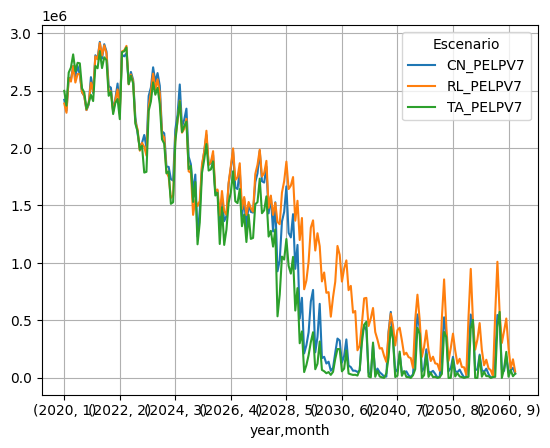

In [ ]:
df_final.pivot_table(index=['year', 'month'], columns='Escenario', values='CO2 emissions [tonCO2eq]', aggfunc='sum').plot(grid=True, )

<Axes: xlabel='year'>

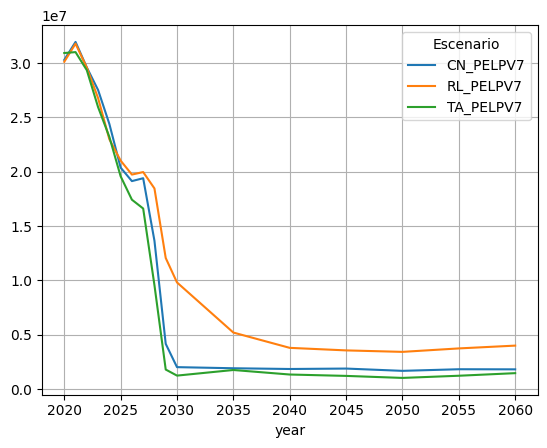

In [ ]:
df_final.pivot_table(index='year', columns='Escenario', values='CO2 emissions [tonCO2eq]', aggfunc='sum').plot(grid=True)

## Inversion Generacion

In [21]:
#######  Costos de Inversión   ######
filepath = []
filename = []
df_final_reg=[]

for root, dirs, files in os.walk(path+r'/Base de Datos/'):
  if dirs: #directorio no vacio
    Escenarios=dirs
  for name in files:
    if name.endswith(("gen_inv_cost.zip")):
      filepath.append(root + os.sep + name)
      filename.append(name)



df_gen_inv_cost = pd.read_csv(filepath[0],sep= ',') #Selecciono un archivo, ya que contiene los 3 escenarios


#### Capacidad nueva de generación
filepath = []
filename = []

#df_agrupacion_tec = pd.read_csv(agrupacion_tec,sep=',',encoding = "ISO-8859-1")
#df_centrales      = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")

for root, dirs, files in os.walk(path+r'/Base de Datos/'):
  if dirs: #directorio no vacio
    Escenarios=dirs
  for name in files:
    if name.endswith(("_Generation investment [MW].csv")):
      filepath.append(root + os.sep + name)
      filename.append(name)



df_gen_inv = pd.DataFrame()

for archivo in filepath:
    df = pd.read_csv(archivo)
    df.index=(pd.DatetimeIndex(df.time)).year
    df2 = pd.DataFrame(columns=df.columns)
    for hid in set(list(df.scenario)):
        for central in set(list(df.generator)):
            df1 =  df.loc[(df.scenario ==hid) & (df.generator ==central)].reindex(idx, fill_value=None)
            df1.scenario = hid
            df1.generator = central
            df1.time = df1.index
            #df1.busbar = df1.busbar.bfill()
            #df1.technology = df1.technology.bfill()
            df1['value [MW]']=round(df1['value [MW]'],2)
            df1['value [MW]'].fillna(value=0,inplace=True)
            df1 = df1.ffill()
            df1.fillna(value=0, inplace= True)
            # df2 = df2.append(df1)
            df2 = pd.concat([df2, df1])
    for escenario in Escenarios:
          if archivo.find("/"+escenario+"/")>=0:
            df2['Escenario'] = escenario
    #df_gen_inv = df_gen_inv.append(df2)
    df_gen_inv = pd.concat([df_gen_inv, df2])


#costo=pd.DataFrame(columns=["Costo Cap"], index=df_gen_cap.index)
costo=pd.DataFrame()
df_gen_inv["Costo Cap [USD/kW]"]=0
esc_costo=""

fila=0
for fila in range(len(df_gen_inv)):
  if df_gen_inv.iloc[fila,3]!=0: #'value [MW]'
    ano = (pd.DatetimeIndex(df_gen_inv_cost.time)).year

    if df_gen_inv.iloc[fila,6].find("Acelerando")>=0 or df_gen_inv.iloc[fila,6].find("Transicion")>=0:
      esc_costo="Bajo"
    if df_gen_inv.iloc[fila,6].find("Rumbo")>=0 or df_gen_inv.iloc[fila,6].find("CN")>=0 or df_gen_inv.iloc[fila,6].find("Referencia")>=0:
      esc_costo="Medio"
    if df_gen_inv.iloc[fila,6].find("Recuperacion")>=0 or df_gen_inv.iloc[fila,6].find("Lenta")>=0:
      esc_costo="Alto"
    if df_gen_inv.iloc[fila,6]=="A": #aca puede ser "CInv_A" o "A"
      esc_costo="A"
    if df_gen_inv.iloc[fila,6]=="B": #aca puede ser "CInv_B" o "B"
      esc_costo="B"
    if df_gen_inv.iloc[fila,6]=="C": #aca puede ser "CInv_C" o "C"
      esc_costo="C"
    if df_gen_inv.iloc[fila,6]=="D": #aca puede ser "CInv_D" o "D"
      esc_costo="D"
    if df_gen_inv.iloc[fila,6]=="E": #aca puede ser "CInv_E" o "E"
      esc_costo="E"

    esc =  df_gen_inv_cost.scenario
    try:  # Ojo acá se pueden estar escondiendo algunos problemas

      df_gen_inv.iloc[fila,7]=round(float(df_gen_inv_cost.loc[(ano==df_gen_inv.index[fila]) & (df_gen_inv_cost.scenario == esc_costo)] [df_gen_inv.iloc[fila,2]]),2)

    except:
      df_gen_inv.iloc[fila,7]=0

df_gen_inv["Inv_Cost_Gen[MMUSD]"]=round(df_gen_inv["value [MW]"]*1000*df_gen_inv["Costo Cap [USD/kW]"]/10**6,2)
df_gen_inv["year"]=df_gen_inv.index
df_gen_inv = df_gen_inv.rename({'scenario':'tuple'},axis=1)


#datos de costos por región
df_centrales = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
df_centrales = df_centrales.rename({'name':'generator'},axis=1)

df_gen_inv_reg = pd.merge(df_gen_inv,df_centrales.loc[:,["generator","region","tecnologia"]],how='left',on='generator')
df_final_reg=df_gen_inv_reg.groupby(['year','tuple','Escenario', 'region','tecnologia']).sum().reset_index()
df_final_reg = df_final_reg.rename({'year':'Año','tuple':'Hidrología','value [MW]':'Valor Capacidad [MW]','region':'Región','tecnologia':'Tecnología'},axis=1)

df_final_reg.to_csv(path+r'/Resumenes/Resumen_anual_regional.csv',index=False,encoding='utf-8-sig',sep=',')

#datos solo por año
df_gen_inv_anual= df_gen_inv.groupby(['tuple','year','Escenario']).sum().reset_index()
df_gen_inv_anual=df_gen_inv_anual.drop(columns=["value [MW]","Costo Cap [USD/kW]"], axis=1)

df_final = pd.merge(df_final, df_gen_inv_anual,on=['year', 'tuple','Escenario'])



KeyboardInterrupt: 

In [7]:
filepath, Escenarios = encontrar_rutas_archivos(path_datos_ameba, "gen_inv_cost.zip")
df_gen_inv_cost = pd.read_csv(filepath[0], sep= ',')
df_gen_inv_cost['year']=(pd.DatetimeIndex(df_gen_inv_cost.time)).year
del df_gen_inv_cost['time']
df_gen_inv_cost = pd.melt(df_gen_inv_cost, id_vars=['year', 'scenario'], var_name='generator', value_name='Costo Cap [USD/kW]')

filepath, Escenarios = encontrar_rutas_archivos(path_datos_ameba, "_Generation investment [MW].csv")

inversion_escenario = {
    'CN_PELPV7': 'Medio',
    'RL_PELPV7': 'Alto',
    'TA_PELPV7': 'Bajo',
}

columnas_centrales = ['name', 'region', 'tecnologia']
df_centrales = pd.read_csv(path_centrales, sep=',', encoding="ISO-8859-1", usecols=columnas_centrales)
df_centrales.rename({'name':'generator', 'region':'Región', 'tecnologia': 'Tecnología'}, axis=1, inplace=True)

df_inversiones = pd.DataFrame()
indice = 0
for archivo in filepath:
    escenario = Escenarios[indice]
    print (f'Procesando {escenario}')
    costos_escenario = df_gen_inv_cost.loc[df_gen_inv_cost.scenario==inversion_escenario[escenario]]
    del costos_escenario['scenario']

    df_escenario = pd.read_csv(archivo, sep=',')
    df_escenario['year']=(pd.DatetimeIndex(df_escenario.time)).year
    df_escenario['Escenario']=escenario
    df_escenario['month']=(pd.DatetimeIndex(df_escenario.time)).month
    del df_escenario['time']

    df_escenario = df_escenario.merge(costos_escenario, on = ['year', 'generator'], how='left')

    df_escenario["Inv_Cost_Gen[MMUSD]"]=round(df_escenario["value [MW]"]*1000*df_escenario["Costo Cap [USD/kW]"]/10**6, 2)
    df_escenario = df_escenario.merge(df_centrales, on = ['generator'], how='left')

    agregacion = {
        'Costo Cap [USD/kW]': 'mean',
        'value [MW]': 'sum',
        'Inv_Cost_Gen[MMUSD]': 'sum'
    }
    df_escenario = df_escenario.groupby(['year','scenario', 'Escenario', 'Región', 'Tecnología']).agg(agregacion).reset_index()
    df_inversiones = pd.concat([df_inversiones, df_escenario])
    indice += 1

Procesando CN_PELPV7
Procesando RL_PELPV7
Procesando TA_PELPV7


<Axes: xlabel='year'>

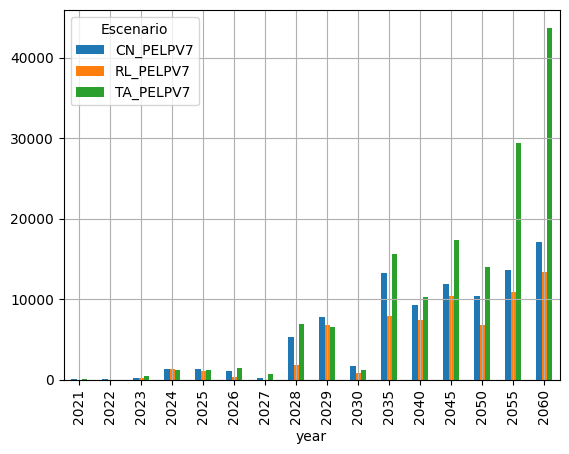

In [15]:
df_inversiones.pivot_table(index=['year'], columns='Escenario', values='Inv_Cost_Gen[MMUSD]', aggfunc='sum').plot(grid=True, kind='bar')

<Axes: xlabel='Región'>

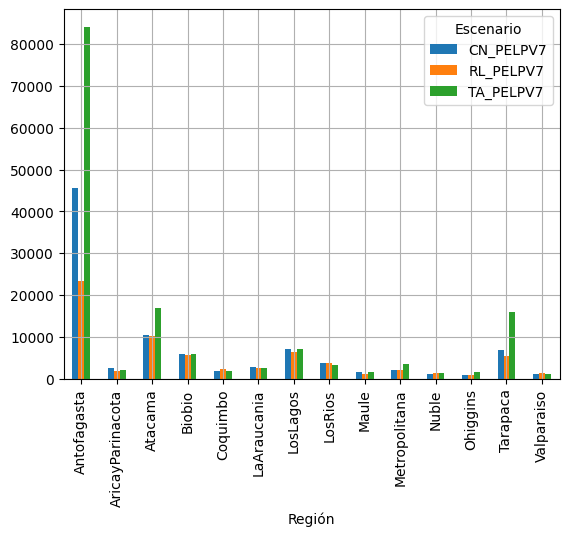

In [16]:
df_inversiones.pivot_table(index=['Región'], columns='Escenario', values='Inv_Cost_Gen[MMUSD]', aggfunc='sum').plot(grid=True, kind='bar')

<Axes: xlabel='year'>

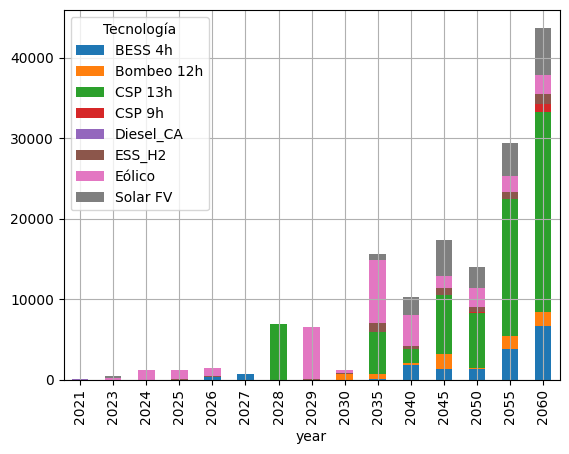

In [20]:
df_inversiones.loc[df_inversiones.Escenario=='TA_PELPV7'].pivot_table(index=['year'], columns='Tecnología', values='Inv_Cost_Gen[MMUSD]', aggfunc='sum').plot(grid=True, kind='bar',stacked=True)

## Capacidad de Generacion

In [ ]:
filepath = []
filepath_pmax = []
filename = []
filename_pmax=[]
df_gen_cap=pd.DataFrame()


for root, dirs, files in os.walk(path+r'/Base de Datos/'):
  if dirs: #directorio no vacio
    Escenarios=dirs
  for name in files:
    if name.endswith(("_Generation investment [MW].csv")):
      filepath.append(root + os.sep + name)
      filename.append(name)
    if name.endswith(("pmax.zip")):
      filepath_pmax.append(root + os.sep + name)
      filename_pmax.append(name)


#preparacion de Diccionario de Centrales para los años base
df_centrales = pd.read_csv(path_centrales,sep=',',encoding = "ISO-8859-1")
aux=df_centrales[(df_centrales["estado"]!="expansion")&(df_centrales["connected"]==True)] #filtrando solo centrales existentes y planes de obra
#centrales_base = aux.iloc[:,[0,1,6,8,41]] #seleccion solo las columnas base
centrales_base = aux.loc[:,["name","start_time","busbar","pmax","tecnologia"]] #seleccion solo las columnas base

centrales_base["start_time"] = centrales_base["start_time"].map(lambda x: "2020-01-01-00:00" if x <= "2020" else x)

centrales_base = centrales_base.rename({'name':'generator'},axis=1)
centrales_base = centrales_base.rename({'start_time':'time'},axis=1)
centrales_base = centrales_base.rename({'pmax':'value [MW]'},axis=1)
centrales_base = centrales_base.rename({'tecnologia':'technology'},axis=1)
centrales_base['Capacidad Acumulado [MW]']=centrales_base['value [MW]']
centrales_base.index=(pd.DatetimeIndex(centrales_base.time)).year #transformacion para coincidir con las columnas
centrales_base.time =centrales_base.index

for archivo in filepath:
    df = pd.read_csv(archivo)
    df.index=(pd.DatetimeIndex(df.time)).year
    df2 = pd.DataFrame(columns=df.columns)

    #encontrando el escenario del archivo
    escenario=""
    for nombre in Escenarios:
          if archivo.find("/"+nombre+"/")>=0:
            escenario = nombre #identifico el escenario del caso
    #retiro de centrales
    archivo_pmax=""
    for archivo in filepath_pmax: #defino cual de los archivos pmax leer segun el escenario
      if archivo.find("/"+escenario+"/")>=0:
        archivo_pmax=archivo

    df_salida_data = pd.read_csv(archivo_pmax,sep=',',encoding = "ISO-8859-1")
    df_pmax=df_centrales.loc[:,["name","pmax","tecnologia","busbar"]] #seleccion las columnas que quiero agregar
    df_salida = pd.merge(df_salida_data,df_pmax,how="left", on="name")
    df_salida["value [MW]"]=df_salida.value - df_salida.pmax
    df_salida['Capacidad Acumulado [MW]']=df_salida.value
    df_salida["time"] = df_salida["time"].map(lambda x: "2021-01-01-00:00" if x <= "2021" else x) #si dejo las salidas antes del año inicial se bloquea
    df_salida = df_salida.rename({'name':'generator'},axis=1)
    df_salida = df_salida.rename({'tecnologia':'technology'},axis=1)
    df_salida=df_salida.drop(["value","pmax"], axis=1)      # estas columnas ya no sirven
    df_salida.index=(pd.DatetimeIndex(df_salida.time)).year #transformacion para coincidir con las columnas

    for nombre in set(list(df.scenario)): # se tiene que agregar cada hidrologia
      aux_scenario=df_salida  # agregando salida centrales
      aux_scenario["scenario"]=nombre
      df=df.append(aux_scenario)

      aux_scenario2=centrales_base  # agregando centrales existentes y plan de obras
      aux_scenario2["scenario"]=nombre
      df=df.append(aux_scenario2)

    for hid in set(list(df.scenario)):
        for central in set(list(df.generator)):
            df1 =  df.loc[(df.scenario ==hid)  & (df.generator ==central)].reindex(idx, fill_value=None )
            df1.scenario = hid
            df1.generator = central
            df1.time = df1.index
            df1.busbar = df1.busbar.bfill()
            df1.technology = df1.technology.bfill()
            df1['value [MW]']=round(df1['value [MW]'],4)
            df1['Capacidad Acumulado [MW]'] = df1['value [MW]']
            df1['Capacidad Acumulado [MW]'] = round(df1['Capacidad Acumulado [MW]'].fillna(0).cumsum(),4)
            df1['value [MW]'].fillna(value=0,inplace=True)
            df1 = df1.ffill()
            df1.fillna(value=0, inplace= True)
            df2 = df2.append(df1)
    df2["Escenario"]=escenario
    df_gen_cap=df_gen_cap.append(df2)


df_gen_cap = df_gen_cap.iloc[:,[0,1,3,6,7]]
df_gen_cap = df_gen_cap.rename({'scenario':'tuple'},axis=1)
df_gen_cap = df_gen_cap.rename({'time':'year'},axis=1)
df_gen_cap = df_gen_cap.rename({'Capacidad Acumulado [MW]':'Capacidad_Gx[MW]'},axis=1)
df_gen_cap=df_gen_cap.drop(['value [MW]'], axis=1)

df_gen_cap_anual= df_gen_cap.groupby(['tuple','year','Escenario']).sum().reset_index()
df_final = pd.merge(df_final, df_gen_cap_anual,on=['year', 'tuple','Escenario'])




## Inversion Transmision

In [ ]:
filepath = []
filename = []
path_output = []
df=[]
df2=[]
df3=[]

for root, dirs, files in os.walk(path+r'/Base de Datos/'):
  if dirs: #directorio no vacio
    Escenarios=dirs
  for name in files:
    if name.endswith(("Transmission investment [MW].csv")):
      filepath.append(root + os.sep + name)
      filename.append(name)

df3 = pd.DataFrame()
for archivo in filepath:
  #encontrando el escenario del archivo
  escenario=""
  for nombre in Escenarios:
    if archivo.find("/"+nombre+"/")>0:
      escenario = nombre


  df = pd.read_csv(archivo)
  df.index=(pd.DatetimeIndex(df.time)).year
  df2 = pd.DataFrame(columns=df.columns)
  for hid in set(list(df.scenario)):
      for rama in set(list(df.branch)):
          df1 =  df.loc[(df.scenario ==hid) & (df.branch ==rama)].reindex(idx, fill_value=None)
          df1.scenario = hid
          df1.branch = rama
          df1.time = df1.index
          df1.initial_busbar = df1.initial_busbar.bfill(axis ='rows')
          df1.initial_busbar = df1.initial_busbar.ffill(axis ='rows')
          #df1.initial_busbar = df1.initial_busbar
          df1.final_busbar = df1.final_busbar.bfill(axis ='rows')
          df1.final_busbar = df1.final_busbar.ffill(axis ='rows')
          #df1 = df1.ffill()
          df1.fillna(value=0, inplace= True)
          df2 = df2.append(df1)

  df2['Escenario'] = escenario
  df3 = df3.append(df2)

df3["value [MW]"]=round(df3["value [MW]"],4)


df_lineas = pd.read_csv(path_lineas,sep=';')
if len(list(df_lineas)) == 1:
    df_lineas = pd.read_csv(path_lineas,sep=',')

df_lineas.columns = map(str.lower, df_lineas.columns)

df_lineas = df_lineas.rename({'name':'branch'},axis=1)
df3 = pd.merge(df3,df_lineas[['branch','branch_inv_cost']],on='branch',how='left')

df3["Inv_Cost_Tx[MMUSD]"]=round(df3["branch_inv_cost"]*df3["value [MW]"]/1000,4)
df3=df3.drop(['branch_inv_cost'], axis=1)

df3 = df3.rename({'scenario':'tuple'},axis=1)
df3 = df3.rename({'time':'year'},axis=1)
df3 = df3.rename({'value [MW]':'Capacidad_Trx[MW]'},axis=1)

df_tx_cap_anual= df3.groupby(['tuple','year','Escenario']).sum().reset_index()

df_final = pd.merge(df_final, df_tx_cap_anual,on=['year', 'tuple','Escenario'])


df_final = df_final.rename({'year':'Año'},axis=1)
df_final = df_final.rename({'tuple':'Hidrologia'},axis=1)
df_final = df_final.rename({'Stage Block generation cost [MMUSD]':'Operation Cost[MMUSD]'},axis=1)
df_final = df_final.rename({'Stage start/stop cost [MMUSD]':'Start Stop Cost[MMUSD]'},axis=1)
df_final = df_final.rename({'CO2 emissions [tonCO2eq]':'CO2 emissions[tonCO2eq]'},axis=1)

df_final.to_csv(path+r'/Resumenes/Resumen_anual.csv',index=False,encoding='utf-8-sig',sep=',')

<ipython-input-217-6d08c3cc7819>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df1)
<ipython-input-217-6d08c3cc7819>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df1)
<ipython-input-217-6d08c3cc7819>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df1)
<ipython-input-217-6d08c3cc7819>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df1)
<ipython-input-217-6d08c3cc7819>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df1)
<ipython-input-217-6d08c3cc781

#Vertimiento (No Usar)

In [ ]:
df_capacidad=pd.read_csv(r"/content/drive/MyDrive/01 Trabajo/01 General DPAIR/01 UPVT/01 PELP/01 Resultados/0. Resultados/2021/PELP quinquenal/Resumenes/Capacidad_total.csv",sep=',')

FileNotFoundError: ignored

In [ ]:
df_capacidad.info()

In [ ]:
df=pd.read_csv(r"/content/drive/MyDrive/01 Trabajo/01 General DPAIR/01 UPVT/01 PELP/01 Resultados/0. Resultados/2021/PELP quinquenal/Base de Datos/Rumbo CN/61253e36be99a4005748ddeb-di_spillage.csv.zip",sep=',',encoding = "ISO-8859-1")

In [ ]:
df[(df.element_name=="FV_Antofagasta_39")&(df.year==2040)].head(24)

In [ ]:
df_final